# [T256075](https://phabricator.wikimedia.org/T256075) Post Deployment Data QA - Collapsible Sidebar Instrumentation

In this task we will be verifying if events fired in the test wikis are making it to the schema [DesktopWebUIActionsTracking](https://meta.wikimedia.org/wiki/Schema:DesktopWebUIActionsTracking) and if the Instrumentation is working correctly.  
**Part 1:**
- euwiki  
- frwiktionary
- ptwikiversity

**Part 2:**
- frwiki
- hewiki
- fawiki

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from tabulate import tabulate
from wmfdata import charting, hive, mariadb
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%d M" % round(x/1000000)
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    return "%d K" % round(x/1000)

You are using wmfdata v1.0.1, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


### Count events in DesktopWebUIActionsTracking

In [2]:
# Count all events  

count_actions = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 20   
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.action
""")

In [3]:
count_actions_pivot=count_actions.pivot(index="date",columns='action', values='events').fillna(0)

In [4]:
count_actions_pivot

action,click,init
date,,
2020-07-22,618,22058
2020-07-23,829,33483
2020-07-24,604,30211
2020-07-25,551,22408
2020-07-26,735,24982
2020-07-27,5922,369904
2020-07-28,26892,1613566
2020-07-29,26605,1539623
2020-07-30,24403,1478869


In [5]:
count_actions_pivot=count_actions_pivot.reset_index()

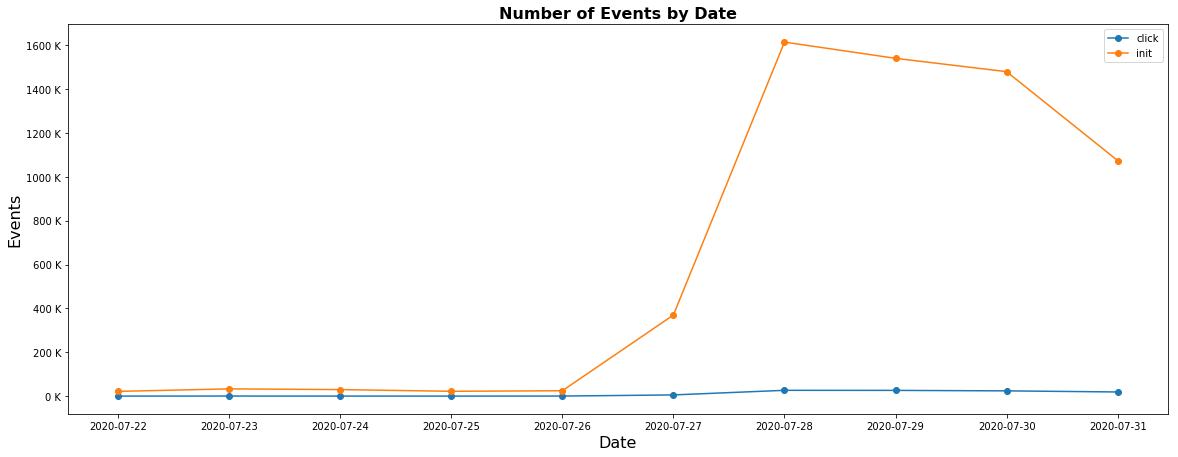

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Number of Events by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_actions_pivot["date"], 
        count_actions_pivot['click'], 'o-', label='click')
ax.plot(count_actions_pivot["date"], 
        count_actions_pivot['init'], 'o-', label='init')


ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper right')

plt.show()

### Count events by Wiki

In [7]:
# Check by Wiki 

count_actions_wiki = hive.run("""
SELECT
  event.action AS action,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 20 
  AND wiki <>'testwiki' 
GROUP BY wiki, event.action
""")

In [8]:
count_actions_wiki_pivot=count_actions_wiki.pivot_table(index=["wiki"],
                                                        columns=["action"], values=['events']).fillna(0)
count_actions_wiki_pivot

events           
action           click       init
wiki                             
enwiki             0.0        2.0
euwiki          1775.0    17015.0
fawiki         12148.0   539630.0
frwiki         68940.0  4892667.0
frwiktionary    4101.0   274311.0
hewiki         19443.0   482555.0
nlwiki             0.0        1.0
ptwikiversity    123.0     2582.0

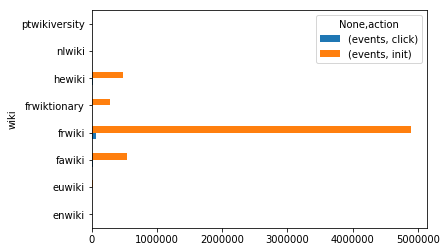

In [10]:
count_actions_wiki_pivot.plot.barh()

### Count events by skinVersion

In [11]:
# Check by skinVersion 

count_actions_skinVersion = hive.run("""
SELECT
  event.action AS action,
  event.skinversion as skinversion,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 19   
  AND wiki <> 'testwiki'
GROUP BY event.action, event.skinversion
""")

In [12]:
count_actions_skinVersion.pivot(index='skinversion', columns='action')

events         
action       click     init
skinversion                
1            82483  5105635
2            24047  1103129

### Count of events by skinVersion on test wikis

In [13]:
# Check by skinVersion and wiki

count_actions_skinVersion_wiki = hive.run("""
SELECT
  event.action AS action,
  event.skinversion as skinversion,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 20   
GROUP BY event.action, event.skinversion, wiki
""")

In [14]:
count_actions_skinVersion_wiki_pivot=count_actions_skinVersion_wiki.pivot_table(index=['wiki','skinversion'],
                                                                                columns=['action']).fillna(0)

In [15]:
count_actions_skinVersion_wiki_pivot

events           
action                       click       init
wiki          skinversion                    
enwiki        1                0.0        2.0
euwiki        1              343.0     1171.0
              2             1435.0    15915.0
fawiki        1             4403.0   107853.0
              2             7865.0   437878.0
frwiki        1            69188.0  4939609.0
              2              287.0      658.0
frwiktionary  1              526.0     5903.0
              2             3580.0   269466.0
hewiki        1             8635.0    99068.0
              2            10954.0   387123.0
nlwiki        1                0.0        1.0
ptwikiversity 1               10.0       48.0
              2              114.0     2558.0
testwiki      1             1962.0     5256.0
              2              948.0      860.0

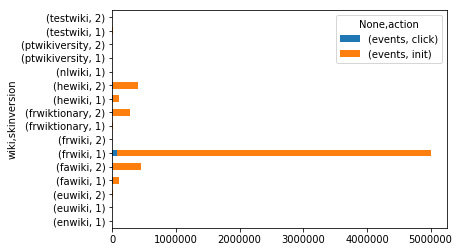

In [18]:
ax = count_actions_skinVersion_wiki_pivot.plot.barh(stacked=True)

### Clicks to the Collapsible Sidebar

In [19]:
# Collapsible sidebar events by Date

count_actions_sidebar = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>20
  AND event.name LIKE 'ui.%'
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name
""")

**Please note : this excludes [Testwiki](https://test.wikipedia.org/wiki/Main_Page)**

In [20]:
count_actions_sidebar_pivot=count_actions_sidebar.pivot(index='date', columns='name')
count_actions_sidebar_pivot

,events
name,ui.sidebar
date,
2020-07-22,305
2020-07-23,425
2020-07-24,244
2020-07-25,225
2020-07-26,294
2020-07-27,350
2020-07-28,1248
2020-07-29,864


In [22]:
count_actions_sidebar_pivot=count_actions_sidebar_pivot.reset_index()

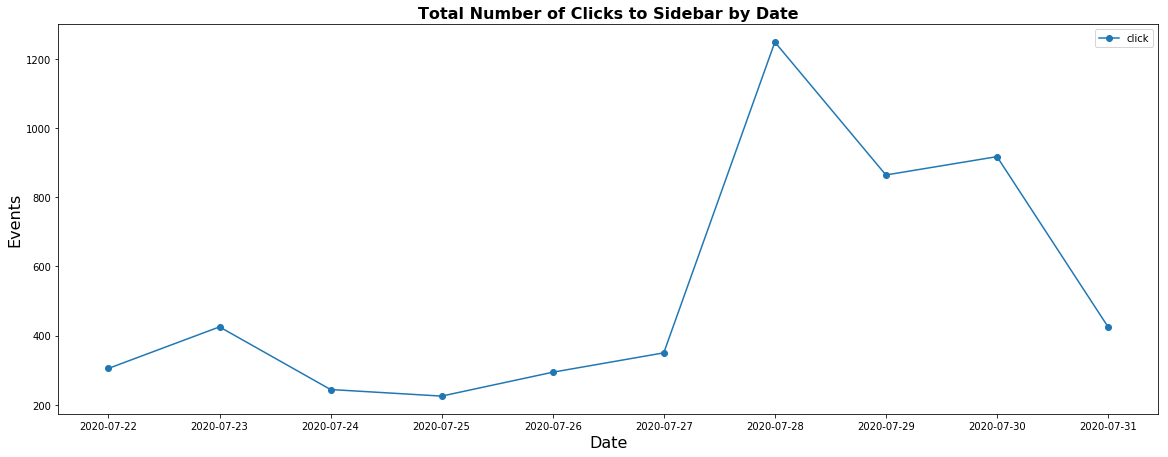

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Total Number of Clicks to Sidebar by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_actions_sidebar_pivot["date"], 
        count_actions_sidebar_pivot['events'], 'o-', label='click')

#ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper right')

plt.show()

### Status of isSidebarCollapsed True/False 

In [97]:
# Collapsible sidebar events 

count_actions_isSidebarCollapsed = hive.run("""
SELECT
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>20
  AND wiki <> 'testwiki'
GROUP BY event.isSidebarCollapsed, event.action
""")

In [103]:
count_actions_isSidebarCollapsed.pivot_table(index=['issidebarcollapsed'], columns=['action'])

events         
action               click     init
issidebarcollapsed                 
False               105050  6155208
True                  3168   174070

In [104]:
# Collapsible sidebar events by Date

count_actions_isSidebarCollapsed_date = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>20
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.isSidebarCollapsed, event.action
""")

In [106]:
count_actions_isSidebarCollapsed_date.pivot_table(index=['issidebarcollapsed','action'], columns=['date'])

events                                   \
date                      2020-07-22 2020-07-23 2020-07-24 2020-07-25   
issidebarcollapsed action                                               
False              click         497        678        463        471   
                   init         1704       1673       1630       1769   
True               click         121        151        141         80   
                   init        20354      31810      28581      20639   

                                                                       \
date                      2020-07-26 2020-07-27 2020-07-28 2020-07-29   
issidebarcollapsed action                                               
False              click         614       5781      26035      26004   
                   init         2173     337311    1600180    1537868   
True               click         121        141        857        601   
                   init        22809      32593      13386       1755   

                                                 
date                      2020-07-30 2020-07-31  
issidebarcollapsed action                        
False              click       23776      20731  
                   init      1477554    1193346  
True               click         627        328  
                   init         1315        828

In [108]:
# Collapsible sidebar events 

count_actions_isSidebarCollapsed_wiki = hive.run("""
SELECT
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  event.action AS action,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>20
  AND wiki <> 'testwiki'
GROUP BY event.isSidebarCollapsed, event.action, wiki
""")

### isSidebarCollapsed True/False by Wiki

In [110]:
count_actions_isSidebarCollapsed_wiki.pivot_table(index=['issidebarcollapsed','action'], columns=['wiki']).fillna(0)

events                                             \
wiki                      enwiki   euwiki    fawiki     frwiki frwiktionary   
issidebarcollapsed action                                                     
False              click     0.0   1580.0   11494.0    70039.0       3396.0   
                   init      2.0  10137.0  549259.0  4991844.0     115975.0   
True               click     0.0    198.0     882.0       56.0        721.0   
                   init      0.0   7015.0    1961.0       41.0     160566.0   

                                                          
wiki                         hewiki nlwiki ptwikiversity  
issidebarcollapsed action                                 
False              click    18464.0    0.0          77.0  
                   init    486789.0    1.0        1201.0  
True               click     1264.0    0.0          47.0  
                   init      3063.0    0.0        1424.0

In [119]:
# Collapsible sidebar events by Wiki and day

count_actions_isSidebarCollapsed_wikiday = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>23
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.isSidebarCollapsed, wiki
""")

### Collapsible sidebar events per day on each test wiki

In [120]:
count_actions_isSidebarCollapsed_wikiday.pivot_table(index=['issidebarcollapsed','date'], 
                                                     columns=['wiki']).fillna(0)

events                               \
wiki                          enwiki  euwiki    fawiki     frwiki   
issidebarcollapsed date                                             
False              2020-07-24    0.0   729.0       0.0        0.0   
                   2020-07-25    0.0   631.0       0.0        0.0   
                   2020-07-26    0.0   677.0       0.0        0.0   
                   2020-07-27    1.0  1073.0   23339.0   290722.0   
                   2020-07-28    0.0  1868.0  150409.0  1315781.0   
                   2020-07-29    1.0  2152.0  147010.0  1251555.0   
                   2020-07-30    0.0  1740.0  132772.0  1206371.0   
                   2020-07-31    0.0  1559.0  111297.0  1044056.0   
True               2020-07-24    0.0  1116.0       0.0        0.0   
                   2020-07-25    0.0   698.0       0.0        0.0   
                   2020-07-26    0.0   869.0       0.0        0.0   
                   2020-07-27    0.0  1283.0       0.0        5.0   
                   2020-07-28    0.0   621.0     784.0       44.0   
                   2020-07-29    0.0     8.0     950.0        2.0   
                   2020-07-30    0.0    11.0     662.0       45.0   
                   2020-07-31    0.0    17.0     479.0        1.0   

                                                                           
wiki                          frwiktionary    hewiki nlwiki ptwikiversity  
issidebarcollapsed date                                                    
False              2020-07-24       1331.0       0.0    0.0          33.0  
                   2020-07-25       1594.0       0.0    0.0          15.0  
                   2020-07-26       2087.0       0.0    0.0          23.0  
                   2020-07-27       1815.0   26120.0    0.0          22.0  
                   2020-07-28      21139.0  136704.0    0.0         314.0  
                   2020-07-29      32419.0  130428.0    0.0         307.0  
                   2020-07-30      30583.0  129563.0    0.0         301.0  
                   2020-07-31      26203.0   85459.0    1.0         239.0  
True               2020-07-24      27353.0       0.0    0.0         253.0  
                   2020-07-25      19880.0       0.0    0.0         141.0  
                   2020-07-26      21909.0       0.0    0.0         152.0  
                   2020-07-27      31177.0       0.0    0.0         269.0  
                   2020-07-28      11220.0    1499.0    0.0          75.0  
                   2020-07-29        179.0    1201.0    0.0          16.0  
                   2020-07-30        166.0    1036.0    0.0          22.0  
                   2020-07-31        107.0     603.0    0.0           6.0

In [57]:
# Collapsible sidebar events by Wiki and date

count_actions_sidebarwiki = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>20
  AND event.name LIKE 'ui.%'
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name, wiki
""")

In [71]:
count_actions_sidebarwiki_pivot=count_actions_sidebarwiki.pivot_table(index=['name','date'], 
                                                                      columns=['wiki']).fillna(0)

### Clicks to the Sidebar Button by Wiki

In [72]:
count_actions_sidebarwiki_pivot

events                                                
wiki                  euwiki fawiki frwiki frwiktionary hewiki ptwikiversity
name       date                                                             
ui.sidebar 2020-07-22   86.0    0.0    0.0        219.0    0.0           0.0
           2020-07-23  124.0    0.0    0.0        295.0    0.0           6.0
           2020-07-24   56.0    0.0    0.0        188.0    0.0           0.0
           2020-07-25   25.0    0.0    0.0        200.0    0.0           0.0
           2020-07-26   33.0    0.0    0.0        261.0    0.0           0.0
           2020-07-27   98.0    0.0    6.0        243.0    0.0           3.0
           2020-07-28   60.0  426.0    2.0        108.0  650.0           2.0
           2020-07-29    5.0  349.0    0.0         64.0  432.0          14.0
           2020-07-30    6.0  350.0   80.0         65.0  405.0          11.0
           2020-07-31   16.0  193.0    0.0         25.0  189.0           2.0

## Donate link events
With the implementation of the Collapsible Sidebar, we are interested to understand in particular, what is the overall difference in interaction with the donate link?

**Donate link name = "n-sitesupport"**


In [44]:
# Donate link events

count_donate_events = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>19
  AND event.name LIKE 'n-site%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name
""")

### Total number of Donate link clicks by date on all test wikis

In [45]:
count_donate_events

,date,name,events
0,2020-07-28,n-sitesupport,42
1,2020-07-31,n-sitesupport,22
2,2020-07-20,n-sitesupport,22
3,2020-07-23,n-sitesupport,264
4,2020-07-29,n-sitesupport,28
5,2020-07-21,n-sitesupport,80
6,2020-07-24,n-sitesupport,2
7,2020-07-27,n-sitesupport,52
8,2020-07-30,n-sitesupport,103


In [48]:
# Donate link events by Wiki

count_donate_wiki = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>24
  AND event.name LIKE 'n-site%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name, wiki
""")

### Donate link clicks by Wiki

In [49]:
count_donate_wiki.pivot_table(index=['wiki','name'], columns=['date']).fillna(0)

events                                   \
date                        2020-07-27 2020-07-28 2020-07-29 2020-07-30   
wiki          name                                                        
euwiki        n-sitesupport        5.0        0.0        0.0        0.0   
fawiki        n-sitesupport        1.0        4.0        7.0       36.0   
frwiki        n-sitesupport        2.0       24.0       17.0       34.0   
frwiktionary  n-sitesupport        4.0        0.0        1.0        0.0   
hewiki        n-sitesupport        1.0       12.0        3.0       29.0   
ptwikiversity n-sitesupport        2.0        0.0        0.0        2.0   
testwiki      n-sitesupport       37.0        2.0        0.0        2.0   

                                        
date                        2020-07-31  
wiki          name                      
euwiki        n-sitesupport        0.0  
fawiki        n-sitesupport        1.0  
frwiki        n-sitesupport       16.0  
frwiktionary  n-sitesupport        1.0  
hewiki        n-sitesupport        4.0  
ptwikiversity n-sitesupport        0.0  
testwiki      n-sitesupport        0.0

In [73]:
# Donate link events on Wikis by skinVersion

count_donate_skinVersion= hive.run("""
SELECT
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>19
  AND event.name LIKE 'n-sitesupport'
GROUP BY event.skinversion, event.name, wiki
""")

### Donate link clicks by Skin Version


In [76]:
count_donate_skinVersion.pivot_table(index=['name','skinversion'], columns=['wiki']).fillna(0)

events                                    \
wiki                      euwiki fawiki frwiki frwiktionary hewiki   
name          skinversion                                            
n-sitesupport 1              0.0    2.0   73.0          0.0   12.0   
              2              5.0   48.0   20.0          6.0   37.0   

                                                  
wiki                      ptwikiversity testwiki  
name          skinversion                         
n-sitesupport 1                     0.0    135.0  
              2                     4.0    274.0

In [77]:
# Donate link events by logged in/out users

count_donate_skinVersion_anon= hive.run("""
SELECT
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  event.isanon AS anonymous_user,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>19
  AND event.name LIKE 'n-sitesupport'
GROUP BY event.skinversion, event.name, wiki, event.isanon 
""")

### Donate link clicks by Skin Version and logged in/out users

In [78]:
count_donate_skinVersion_anon.pivot_table(index=['name','anonymous_user','skinversion'], columns=['wiki']).fillna(0)

events                             \
wiki                                     euwiki fawiki frwiki frwiktionary   
name          anonymous_user skinversion                                     
n-sitesupport False          1              0.0    0.0    3.0          0.0   
                             2              0.0    0.0    0.0          0.0   
              True           1              0.0    2.0   70.0          0.0   
                             2              5.0   48.0   20.0          6.0   

                                                                        
wiki                                     hewiki ptwikiversity testwiki  
name          anonymous_user skinversion                                
n-sitesupport False          1              5.0           0.0     59.0  
                             2              1.0           0.0    164.0  
              True           1              7.0           0.0     76.0  
                             2             36.0           4.0    110.0

In [79]:
# Donate link events by logged in/out users by day

count_donate_skinVersion_anon_day= hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  event.isanon AS anonymous_user,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>23
  AND event.name LIKE 'n-sitesupport'
GROUP BY date_format(dt, "yyyy-MM-dd"),event.skinversion, event.name, wiki, event.isanon 
""")

### Daily count of Donate link clicks by Skin Version for logged in/out users

In [83]:
count_donate_skinVersion_anon_day.pivot_table(index=
                                              ['name','anonymous_user','skinversion','date'], 
                                              columns=['wiki']).fillna(0)

events                \
wiki                                                euwiki fawiki frwiki   
name          anonymous_user skinversion date                              
n-sitesupport False          1           2020-07-28    0.0    0.0    0.0   
                                         2020-07-29    0.0    0.0    0.0   
                                         2020-07-30    0.0    0.0    2.0   
                                         2020-07-31    0.0    0.0    1.0   
                             2           2020-07-30    0.0    0.0    0.0   
              True           1           2020-07-24    0.0    0.0    0.0   
                                         2020-07-27    0.0    1.0    2.0   
                                         2020-07-28    0.0    1.0   24.0   
                                         2020-07-29    0.0    0.0   17.0   
                                         2020-07-30    0.0    0.0   12.0   
                                         2020-07-31    0.0    0.0   15.0   
                             2           2020-07-27    5.0    0.0    0.0   
                                         2020-07-28    0.0    3.0    0.0   
                                         2020-07-29    0.0    7.0    0.0   
                                         2020-07-30    0.0   36.0   20.0   
                                         2020-07-31    0.0    2.0    0.0   

                                                                         \
wiki                                                frwiktionary hewiki   
name          anonymous_user skinversion date                             
n-sitesupport False          1           2020-07-28          0.0    4.0   
                                         2020-07-29          0.0    1.0   
                                         2020-07-30          0.0    0.0   
                                         2020-07-31          0.0    0.0   
                             2           2020-07-30          0.0    1.0   
              True           1           2020-07-24          0.0    0.0   
                                         2020-07-27          0.0    1.0   
                                         2020-07-28          0.0    6.0   
                                         2020-07-29          0.0    0.0   
                                         2020-07-30          0.0    0.0   
                                         2020-07-31          0.0    0.0   
                             2           2020-07-27          4.0    0.0   
                                         2020-07-28          0.0    2.0   
                                         2020-07-29          1.0    2.0   
                                         2020-07-30          0.0   28.0   
                                         2020-07-31          1.0    4.0   

                                                                            
wiki                                                ptwikiversity testwiki  
name          anonymous_user skinversion date                               
n-sitesupport False          1           2020-07-28           0.0      0.0  
                                         2020-07-29           0.0      0.0  
                                         2020-07-30           0.0      0.0  
                                         2020-07-31           0.0      0.0  
                             2           2020-07-30           0.0      0.0  
              True           1           2020-07-24           0.0      2.0  
                                         2020-07-27           0.0      0.0  
                                         2020-07-28           0.0      1.0  
                                         2020-07-29           0.0      0.0  
                                         2020-07-30           0.0      0.0  
                                         2020-07-31           0.0      0.0  
                             2           2020-07-27           2.0     37.0  
                          

In [88]:
# Other Sidebar links

count_sidebar_links_click= hive.run("""
SELECT
  event.skinversion,
  event.isanon AS anonymous_user,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>23
  AND event.name LIKE 'n-%' 
  AND wiki <> 'testwiki' 
  
GROUP BY event.skinversion, event.name, event.isanon 
""")

### Clicks to other sidebar links that have been logged in the schema

In [91]:
count_sidebar_links_click.head()

,skinversion,anonymous_user,name,events
0,1,False,n-La-Wikidémie,5
1,1,True,n-Town-square,6
2,1,True,n-aboutwp,176
3,1,False,n-bistro,73
4,1,True,n-contact,210


## Verifying a few row of data in the schema

In [ ]:
# Other Sidebar links

count_sidebar_links_click= hive.run("""
SELECT
  
  event.skin,
  event.action, 
  event.skinversion,
  event.isanon AS anonymous_user,
  event.name as name,
  event.token,
  
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day=30 AND hour=11
  AND wiki <> 'testwiki' 
  
GROUP BY event.skinversion, event.name, event.isanon 
""")